In [1]:
import sys
sys.path.insert(0, './jaxkd/')

In [2]:
import time
start = time.time()

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

In [4]:
import numpy as np
import jax
import jaxkd
import jax.numpy as jnp
import matplotlib.pyplot as plt

# jax.config.update("jax_enable_x64", False)
# jax.config.update("jax_platforms", 'cpu')

import ImageD11.sinograms.dataset
import ImageD11.sinograms.tensor_map
import ImageD11.sinograms.geometry
from ImageD11.sinograms.point_by_point import PBPRefine
import transform as mytrans
import index as myidx

%matplotlib widget

In [5]:
def _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega):
    dty = y0 - sx * sinomega - sy * cosomega
    return dty

def _dty_values_grain_in_beam(sx, sy, y0, omega):
    """Calls dty_values_grain_in_beam_sincos after converting omega (degrees) into sinomega, cosomega"""
    omega_rad = jnp.radians(omega)
    sinomega = jnp.sin(omega_rad)
    cosomega = jnp.cos(omega_rad)
    return _dty_values_grain_in_beam_sincos(sx, sy, y0, sinomega, cosomega)

def _step_to_sample(si, sj, ystep):
    """Converts step space (si, sj) to sample position (sx, sy)"""
    sx = si * ystep
    sy = -sj * ystep
    return sx, sy

def _recon_to_step(ri, rj, recon_shape):
    """Converts reconstruction space (ri, rj) to step space (si, sj)"""
    si = ri - (recon_shape[0] // 2)
    sj = rj - (recon_shape[1] // 2)
    return si, sj

def _recon_to_sample(ri, rj, recon_shape, ystep):
    """Converts reconstruction space (ri, rj) to sample space (sx, sy)"""
    si, sj = _recon_to_step(ri, rj, recon_shape)
    sx, sy = _step_to_sample(si, sj, ystep)
    return sx, sy

def _recon_omega_to_dty(ri, rj, omega, y0, recon_shape, ystep):
    """
    Convert recon space (ri, rj) to step space (si, sj)
    Then get corresponding dty values which puts (si, sj) into the beam given omega
    """
    sx, sy = _recon_to_sample(ri, rj, recon_shape, ystep)
    dty = _dty_values_grain_in_beam(sx, sy, y0, omega)
    return dty

recon_omega_to_dty = jax.jit(jax.vmap(_recon_omega_to_dty, in_axes=[0,0,0,None,None,None]))

In [6]:
os.chdir('/home/esrf/james1997a/Data/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/')

In [7]:
ds = ImageD11.sinograms.dataset.load('FeAu_0p5_tR_nscope_top_200um_dataset.h5')

In [8]:
phases = ds.get_phases_from_disk()
ref_ucell = phases.unitcells['Fe']

In [9]:
cf_2d = ds.get_cf_2d_from_disk()

Reading your columnfile in hdf format


In [10]:
ds.update_colfile_pars(cf_2d, 'Fe')

In [11]:
pars = cf_2d.parameters
pars.get_parameters()

{'filename': '/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_2d.h5',
 'chi': 0.0,
 'distance': 152736.55305695778,
 'fit_tol': 0.05,
 'fit_tolerance': 0.05,
 'min_bin_prob': 1e-05,
 'no_bins': 10000,
 'o11': -1,
 'o12': 0,
 'o21': 0,
 'o22': -1,
 'omegasign': 1.0,
 't_x': 0,
 't_y': 0,
 't_z': 0,
 'tilt_x': 0.0,
 'tilt_y': -0.0017891961941669614,
 'tilt_z': -4.426909440152746e-05,
 'wavelength': 0.2845704,
 'wedge': 0.0,
 'weight_hist_intensities': 'False',
 'y_center': 1049.9295061162281,
 'y_size': 75.0,
 'z_center': 1116.4472483389864,
 'z_size': 75.0,
 'cell__a': 2.8694,
 'cell__b': 2.8694,
 'cell__c': 2.8694,
 'cell_alpha': 90.0,
 'cell_beta': 90.0,
 'cell_gamma': 90.0,
 'cell_lattice_[P,A,B,C,I,F,R]': 229}

In [12]:
# tmap = ImageD11.sinograms.tensor_map.TensorMap.from_h5('FeAu_0p5_tR_nscope_top_200um_grains.h5', 'TensorMap_Fe')
tmap = ImageD11.sinograms.tensor_map.TensorMap.from_h5('FeAu_0p5_tR_nscope_top_200um_tmap_Fe.h5')

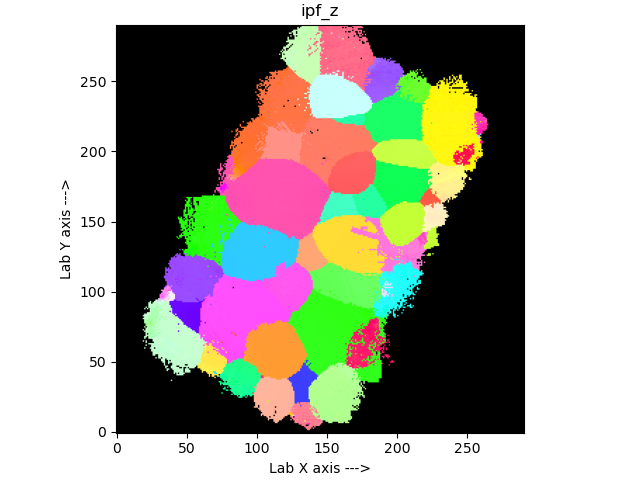

In [13]:
tmap.plot('ipf_z')

In [14]:
# get the UB map in reconstruction space

UB_recon_space = tmap.map_order_to_recon_order( tmap.UB, z_layer=0 )
UB_recon_space.shape

(291, 291, 3, 3)

In [15]:
# get a mask to the UB map in reconstruction shape
todo = ~np.isnan(UB_recon_space[:,:,0,0])

In [16]:
ref_ucell.makerings(cf_2d.ds.max())
hkls = []
mults = []
for i, d in enumerate(ref_ucell.ringds):
    hklring = ref_ucell.ringhkls[d]
    mults.append( len(hklring) )
    print(i, len(hklring),hklring[0],d)
    hkls += list(hklring)

0 12 (0, -1, -1) 0.4928603758183226
1 6 (0, 0, -2) 0.6970098278385725
2 24 (-1, -2, -1) 0.853659211954826
3 12 (-2, 0, -2) 0.9857207516366452
4 24 (0, -3, -1) 1.1020693037458629
5 8 (-2, -2, -2) 1.2072564351912436
6 48 (-2, -1, -3) 1.303985985493114
7 6 (0, -4, 0) 1.394019655677145
8 36 (-4, -1, -1) 1.4785811274549678
9 24 (0, -4, -2) 1.5585613560324734
10 24 (-3, -2, -3) 1.6346329406229279
11 24 (-4, -2, -2) 1.707318423909652
12 72 (-1, -3, -4) 1.7770333566574141
13 48 (-2, -5, -1) 1.9088400275498922
14 12 (-4, -4, 0) 1.9714415032732904
15 48 (-3, -3, -4) 2.0321153881805603
16 30 (0, -6, 0) 2.0910294835157175
17 72 (-6, -1, -1) 2.148328571467546
18 24 (-6, 0, -2) 2.2041386074917257


In [17]:
hkls = np.array(hkls)
print(hkls)
hkls.shape

[[ 0 -1 -1]
 [-1  0 -1]
 [ 1  0 -1]
 ...
 [ 6  2  0]
 [ 2  0  6]
 [ 6  0  2]]


(554, 3)

In [18]:
# mask UB matrices by valid pixels

voxel_ub = UB_recon_space[ todo ]
voxel_ub.shape

(41479, 3, 3)

In [19]:
%%time
# Axes are [voxel, ub_i, ub_j ] . hkls[ npeaks, hkl ]
gvecs = jnp.einsum( 'vij,hj->vhi', voxel_ub, hkls).reshape(-1, 3)

CPU times: user 128 ms, sys: 48.4 ms, total: 177 ms
Wall time: 172 ms


In [20]:
gvecs.shape

(22979366, 3)

In [21]:
os.chdir('/home/esrf/james1997a/Code/Anri/anri/sandbox/')

In [22]:
wedge = pars.get('wedge')
chi = pars.get('chi')
wavelength = pars.get('wavelength')

In [23]:
tth, [eta1, eta2], [omega1, omega2] = mytrans.g_to_tth_eta_omega(gvecs, wedge, chi, wavelength)

In [24]:
%%time
NY = UB_recon_space.shape[0]
ii, jj = np.mgrid[ 0:NY, 0:NY ]
vi = ii[todo]
vj = jj[todo]
y0 = -16.0

s = voxel_ub.shape[0], len(hkls)
omega1 = omega1.reshape(s)
omega2 = omega2.reshape(s)

dty1 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega1,y0,UB_recon_space.shape, ds.ystep)
dty2 = recon_omega_to_dty(vi[:,np.newaxis],vj[:,np.newaxis],omega2,y0,UB_recon_space.shape, ds.ystep)

CPU times: user 163 ms, sys: 56.9 ms, total: 220 ms
Wall time: 108 ms


In [25]:
dty1 = dty1.reshape(eta1.shape)
dty2 = dty2.reshape(eta1.shape)

omega1 = omega1.reshape(eta1.shape)
omega2 = omega2.reshape(eta1.shape)

In [26]:
# fig, ax = plt.subplots()
# ax.scatter(omega1[:5000], dty1[:5000], c=eta1[:5000], s=1)
# plt.show()

In [27]:
tth_calc = jnp.transpose(jnp.array([tth, tth])).flatten()
eta_calc = jnp.transpose(jnp.array([eta1, eta2])).flatten()
omega_calc = jnp.transpose(jnp.array([omega1, omega2])).flatten()
dty_calc = jnp.transpose(jnp.array([dty1, dty2])).flatten()

In [28]:
# Nvoxels = 36968
# Nhkls = 554
# Npeaks_calc = 40960544 = (Nvoxels * Nhkls * 2)
# Npeaks_obs = 19112858

In [29]:
# calculted coordinates for each peak - derived from ubi and hkls

w_tth = 1
w_eta = 1
w_omega = 1
w_dty = 1

coords_calc = jnp.column_stack((w_tth * tth_calc, w_eta * (eta_calc%360), w_omega * (omega_calc%360), w_dty*dty_calc))

In [30]:
# observed coordinates for each peak - from the detector
coords_obs = jnp.column_stack((w_tth * cf_2d.tth,  w_eta * (cf_2d.eta%360), w_omega * (cf_2d.omega%360), w_dty*cf_2d.dty))

In [31]:
%%time

from scipy.spatial import KDTree
tree_obs = KDTree(coords_obs)

# for each calculated peak (with shape voxels*hkls*2), give me the index to the nearest observed peak
dd, ii_calc = tree_obs.query(coords_calc, k=1, workers=35)

CPU times: user 14min 25s, sys: 7.2 s, total: 14min 32s
Wall time: 42.9 s


In [32]:
# (nub, npeaks_calc)
ii_calc = ii_calc.reshape(-1, 2*hkls.shape[0])

In [33]:
gve_obs = np.column_stack((cf_2d.gx, cf_2d.gy, cf_2d.gz))

In [34]:
g_obs_for_ub = gve_obs[ii_calc]

In [35]:
# Axes are [voxel, ubi_i, ubi_j ] . gve[ voxel, nhkl, 3 ]
hkls_obs = jnp.einsum( 'vij,vhj->vhi', np.linalg.inv(voxel_ub), g_obs_for_ub)

In [36]:
hkls_obs_int = jnp.rint(hkls_obs)

dhkl = hkls_obs - hkls_obs_int
drlv2 = jnp.sum(dhkl**2, axis=2)

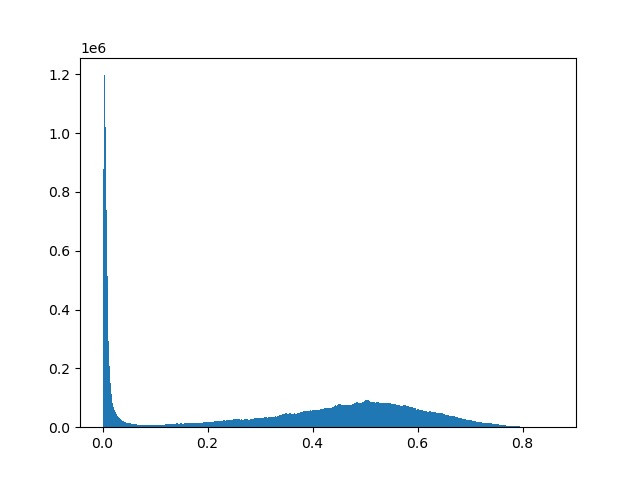

In [37]:
fig, ax = plt.subplots()
ax.hist(np.sqrt(drlv2.ravel()), bins=1000)
plt.show()

In [38]:
tol = 0.1

In [39]:
mask = drlv2 < tol**2

In [40]:
# santiy check - pick a (ub, peak) with a good match

In [41]:
# calculated indices
ci, cj = list(zip(*np.where(mask)))[0]
# calculated indices unravelled
cir = ci*voxel_ub.shape[0]+cj
# observed indices
oi = ii_calc[ci, cj]

In [42]:
cf_2d.tth[oi], cf_2d.eta[oi], cf_2d.omega[oi], cf_2d.dty[oi]

(8.021153149956064, -165.00016695262252, 165.0551631823417, -70.00000319994166)

In [43]:
tth_calc[cir], eta_calc[cir], omega_calc[cir], dty_calc[cir]

(Array(8.04979375, dtype=float64),
 Array(-164.86339331, dtype=float64),
 Array(165.06069814, dtype=float64),
 Array(-70.84426403, dtype=float64))

In [44]:
mask.shape

(41479, 1108)

In [45]:
drlv2_nan = jnp.where(mask, drlv2, jnp.nan)

In [46]:
drlv2_mean = jnp.nanmean(drlv2_nan, axis=1)

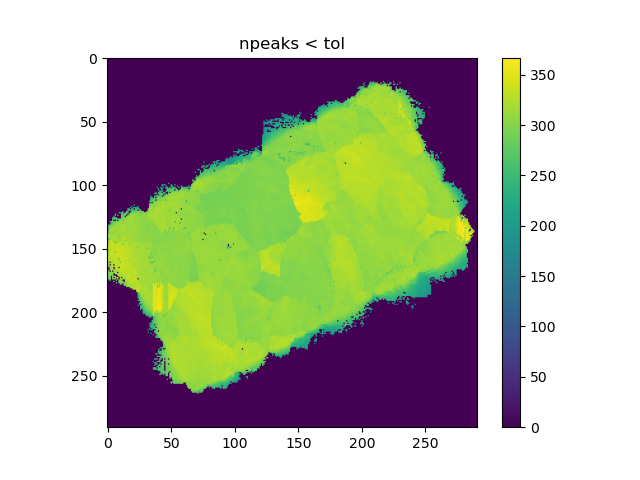

In [47]:
npks_img = np.zeros(todo.shape)
npks_img[todo] = mask.sum(axis=1) 

fig, ax = plt.subplots()
im = ax.imshow(npks_img)
plt.colorbar(im)
ax.set(title='npeaks < tol')
plt.show()

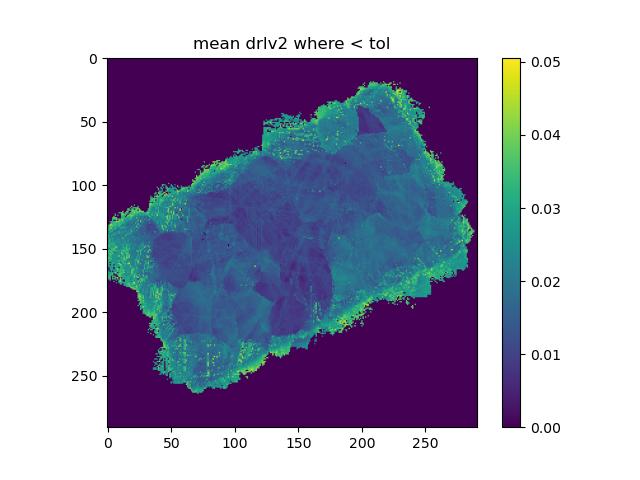

In [48]:
drlv_img = np.zeros(todo.shape)
drlv_img[todo] = drlv2_mean

fig, ax = plt.subplots()
im = ax.imshow(jnp.sqrt(drlv_img))
plt.colorbar(im)
ax.set(title='mean drlv2 where < tol')
plt.show()

In [49]:
end = time.time()
print(end-start)

68.41826605796814
